In [20]:
import os
import ast
import cv2
import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image, ImageStat
from torchvision.io import read_image, ImageReadMode
from torchvision.models import convnext_large, ConvNeXt_Large_Weights

from neuralpredictors.measures.np_functions import corr, fev

In [2]:
def custom_agg(series):
    array = np.array([ast.literal_eval(x) for x in series])
    array = np.mean(array, axis=0)
    return array.tolist()

In [3]:
def voc_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [4]:
datasets = ["pretrain_21067-10-18", "pretrain_23343-5-17", "pretrain_22846-10-16",
            "pretrain_23656-14-22", "pretrain_23964-4-22", "sensorium_26872-17-20",
            "sensorium+_27204-5-13"]
data_keys = [key.split("_")[1] for key in datasets]

In [5]:
frame_image_id = {}
for data_key in data_keys[:5]:
    frame_image_id[data_key] = np.load(f"./dataset/pretrain_{data_key}/meta/trials/frame_image_id.npy")

In [6]:
preds_gt = {}
for data_key in data_keys[:5]:
    pred = pd.read_csv(f"./for_paper/curBest_onchannel_noEnsemble/preds_gt/{data_key}/submission_file_live_test.csv")
    gt = pd.read_csv(f"./for_paper/curBest_onchannel_noEnsemble/preds_gt/{data_key}/ground_truth_file_test.csv")
    pred = pd.merge(pred, gt, how="left", on=["trial_indices", "image_ids", "neuron_ids"])
    preds_gt[data_key] = pred

In [7]:
avg_preds_gt = preds_gt.copy()
for data_key in data_keys[:5]:
    avg_preds_gt[data_key] = avg_preds_gt[data_key].groupby("image_ids")\
        .agg({"prediction": custom_agg, 
              "responses": custom_agg,
              "neuron_ids": custom_agg})
    avg_preds_gt[data_key].reset_index(inplace=True)
    
    mean_responses = np.vstack(avg_preds_gt[data_key].responses)
    mean_predictions = np.vstack(avg_preds_gt[data_key].prediction)
    correlation = corr(mean_responses, mean_predictions, axis=1)
    avg_preds_gt[data_key]["correlation"] = correlation
    
    true_image_ids = [np.where(frame_image_id[data_key] == the_id)[0][0] for the_id in avg_preds_gt[data_key].image_ids]
    avg_preds_gt[data_key]["true_image_ids"] = true_image_ids

In [8]:
def summary(x: list):
    return [np.min(x), np.median(x), np.max(x), np.mean(x), np.std(x)]

# statistically summarize the response for each image
merge_preds_gt = pd.DataFrame()
for data_key in data_keys[:5]:
    df = preds_gt[data_key].copy()
    df["dataset"] = data_key
    merge_preds_gt = pd.concat([merge_preds_gt, df], ignore_index=True)
    
response_summary = [summary(ast.literal_eval(x)) for x in merge_preds_gt.responses.values]

In [9]:
cols = ["response_min", "response_median", "response_max", "response_mean", "response_std"]
response_summary = np.array(response_summary)
response_summary = pd.DataFrame(response_summary, columns=cols)
pd.concat([merge_preds_gt, response_summary], axis=1)[["image_ids", "dataset"]+cols].to_csv("image_response_summary.csv", index=False)

In [10]:
# statistically summarize the response for each image after merging the repeats
merge_avg_preds_gt = pd.DataFrame()
for data_key in data_keys[:5]:
    df = avg_preds_gt[data_key].copy()
    df["dataset"] = data_key
    merge_avg_preds_gt = pd.concat([merge_avg_preds_gt, df], ignore_index=True)
    
cols = ["response_min", "response_median", "response_max", "response_mean", "response_std"]
response_summary = np.array([summary(x) for x in merge_avg_preds_gt.responses.values])
response_summary = pd.DataFrame(response_summary, columns=cols)

pd.concat([merge_avg_preds_gt, response_summary], axis=1)[["image_ids", "dataset"]+cols].to_csv("image_mergeRep_response_summary.csv", index=False)

cols = ["preds_min", "preds_median", "preds_max", "preds_mean", "preds_std"]
preds_summary = np.array([summary(x) for x in merge_avg_preds_gt.prediction.values])
preds_summary = pd.DataFrame(preds_summary, columns=cols)

pd.concat([merge_avg_preds_gt, preds_summary], axis=1)[["image_ids", "dataset"]+cols].to_csv("image_mergeRep_preds_summary.csv", index=False)

In [11]:
preds_summary

,preds_min,preds_median,preds_max,preds_mean,preds_std
0,0.004961,0.104070,2.154711,0.169729,0.198365
1,0.008125,0.160038,2.414042,0.221199,0.214734
2,0.004758,0.206426,4.240042,0.301290,0.309019
3,0.003928,0.146251,3.978221,0.231314,0.281331
4,0.004374,0.232091,4.551473,0.374112,0.425195
...,...,...,...,...,...
495,0.003775,0.211649,3.699303,0.299468,0.292259
496,0.002243,0.196032,2.572484,0.287325,0.287086
497,0.008047,0.194964,4.061316,0.333045,0.395876
498,0.005556,0.185047,2.380673,0.255056,0.235894


In [12]:
# save all images of test data
for idx, row in avg_preds_gt["21067-10-18"].iterrows():
    trial_id = row["image_ids"]
    image_id = row["true_image_ids"]
    os.system(f"cp images_png/pretrain_21067-10-18/data/images/{image_id}.png outputs_model_with_image/{trial_id}.png")

In [13]:
# correlation for the test images in each dataset
merge_preds_gt = pd.DataFrame()
for data_key in data_keys[:5]:
    df = avg_preds_gt[data_key].copy()
    df["dataset"] = data_key
    merge_preds_gt = pd.concat([merge_preds_gt, df], ignore_index=True)
    
merge_preds_gt = merge_preds_gt[["image_ids", "correlation", "dataset"]]
merge_preds_gt.to_csv("outputs_model_with_image/image_performance.csv", index=False)

In [14]:
def calculate_brightness(image):
    greyscale_image = image.convert('L')
    histogram = greyscale_image.histogram()
    pixels = sum(histogram)
    brightness = scale = len(histogram)

    for index in range(0, scale):
        ratio = histogram[index] / pixels
        brightness += ratio * (-scale + index)

    return 1 if brightness == 255 else brightness / scale

# calculate image complexity use the spatial information
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6603194
SI_means = []
for trial_id in avg_preds_gt["21067-10-18"].image_ids:
    img = cv2.imread(f"./outputs_model_with_image/images/{trial_id}.png", cv2.IMREAD_GRAYSCALE)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the gradient magnitude
    SI_r = np.sqrt(sobelx**2 + sobely**2)
    SI_means.append(np.mean(SI_r))
    
brightness = []
contrast = []
for trial_id in avg_preds_gt["21067-10-18"].image_ids:
    img = Image.open(f"./outputs_model_with_image/images/{trial_id}.png")
    stat = ImageStat.Stat(img)
    brightness.append(stat.mean[0])
    contrast.append(stat.stddev[0])
    
    # brightness.append(calculate_brightness(img))
    
image_complexity = pd.DataFrame({"image_ids": avg_preds_gt["21067-10-18"].image_ids,
                                 "Complexity": SI_means,
                                 "Brightness": brightness,
                                 "Contrast": contrast})
image_complexity.to_csv("./outputs_model_with_image/image_complexity.csv", index=False)

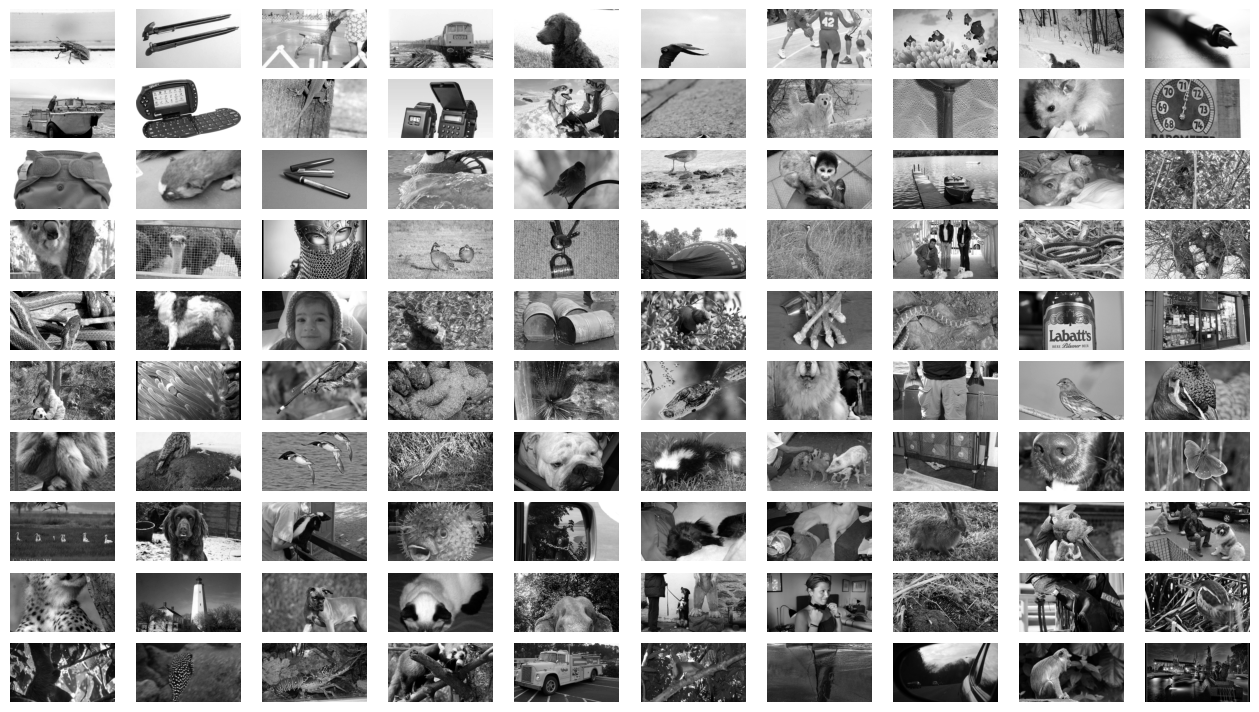

In [15]:
plot_order = image_complexity.sort_values(by="Brightness", ascending=False).image_ids.tolist()
fig, ax = plt.subplots(10, 10, figsize=(16, 9))
for idx, image_id in enumerate(plot_order):
    image = Image.open(f"./images_test/{image_id}.png")
    ax[idx//10][idx%10].imshow(image, cmap="gray")
    ax[idx//10][idx%10].set_axis_off()

In [16]:
# image bbox number, box areas, merged box areas
merge_preds_gt = pd.DataFrame()
for data_key in data_keys[:5]:
    df = avg_preds_gt[data_key].copy()
    df["dataset"] = data_key
    
    bbox_num = []
    xywh_area = []
    xywh_x = []
    xywh_y = []
    for idx, row in df.iterrows():
        annos = json.load(open(f"./dataset/pretrain_{data_key}/data/anno_auto/{row['true_image_ids']}.json"))
        bbox_num.append(len(annos["boxes"]))
        
        xywh = np.load(f"./dataset/pretrain_{data_key}/data/xywh/{row['true_image_ids']}.npy")
        xywh_x.append(xywh[0])
        xywh_y.append(xywh[1])
        xywh_area.append(xywh[2] * xywh[3])
    
    df["bbox_num"] = bbox_num
    df["xywh_area"] = xywh_area
    df["xywh_x"] = xywh_x
    df["xywh_y"] = xywh_y

    merge_preds_gt = pd.concat([merge_preds_gt, df], ignore_index=True)

# merge_preds_gt.to_csv("./outputs_model_with_image/image_bboxes.csv", index=False)
merge_preds_gt[["image_ids", "correlation", "dataset", "bbox_num", "xywh_area", "xywh_x", "xywh_y"]] \
    .to_csv("./outputs_model_with_image/image_bboxes.csv", index=False)

In [34]:
merge_preds_gt[merge_preds_gt.image_ids == 4812]

,image_ids,prediction,responses,neuron_ids,correlation,true_image_ids,dataset,bbox_num,xywh_area,xywh_x,xywh_y
59,4812,"[0.12497200071811676, 0.13408683240413666, 0.1...","[0.12370483060266442, 0.060456363310002856, 0....","[1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",0.599475,1240,21067-10-18,3,0.635213,0.509236,0.443814
159,4812,"[0.2657017707824707, 0.3451644480228424, 0.159...","[0.08874684739623655, 0.4046524488445181, 0.39...","[1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 11.0, 12.0...",0.602356,5665,23343-5-17,3,0.635213,0.509236,0.443814
259,4812,"[0.03566925600171089, 0.17210730910301208, 0.1...","[0.021596846947425793, 0.020593805564203056, 0...","[1.0, 2.0, 3.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0...",0.756076,46,22846-10-16,3,0.635213,0.509236,0.443814
359,4812,"[0.2245979607105255, 0.02280576154589653, 0.56...","[0.14549254523626448, 0.0036206745166978693, 0...","[1.0, 2.0, 3.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0...",0.698998,5678,23656-14-22,3,0.635213,0.509236,0.443814
459,4812,"[0.6018220782279968, 0.3600963056087494, 1.027...","[0.27288486224046665, 0.41638131084511565, 0.1...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",0.703320,459,23964-4-22,3,0.635213,0.509236,0.443814


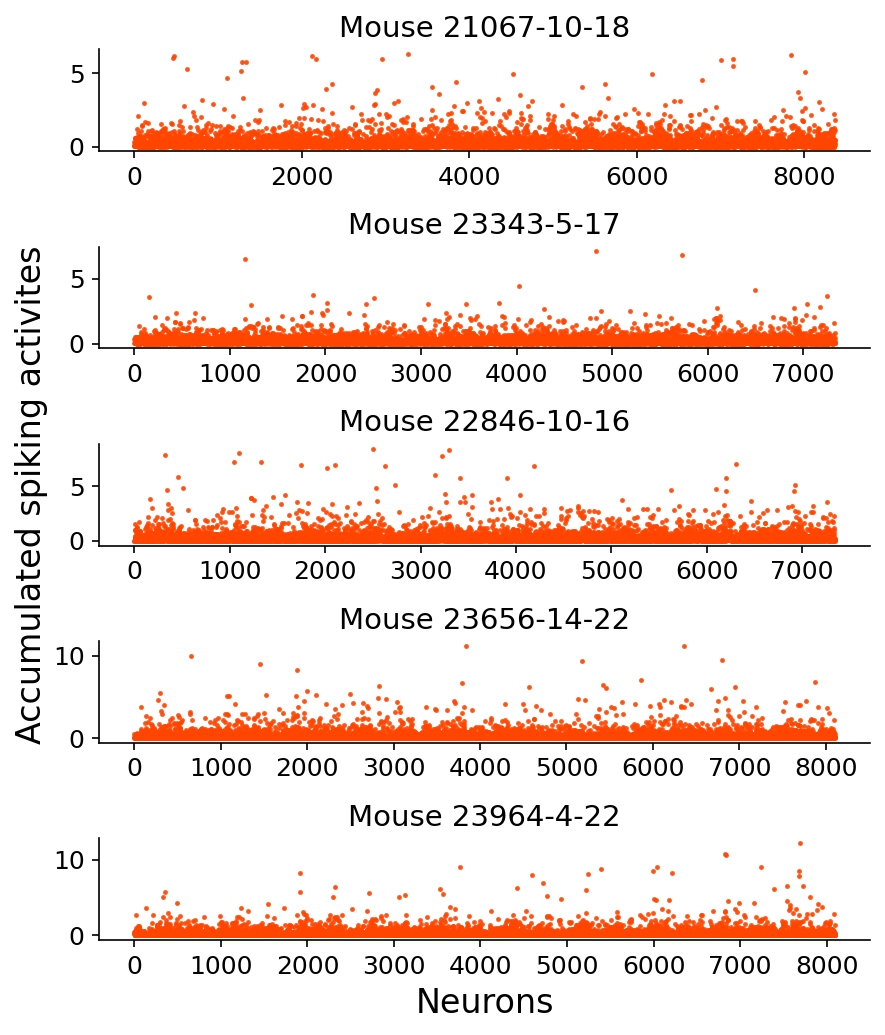

In [ ]:
# prepare for Figure 1A
image = np.load("./dataset/pretrain_21067-10-18/data/images/1240.npy")
image = np.transpose(image, (1, 2, 0))

# figure = plt.figure(figsize=(12, 5), dpi=150, facecolor="#ffffff")
# gs = GridSpec(nrows=5, ncols=2)

# ax0 = figure.add_subplot(gs[:, 0])
# ax0.imshow(image, cmap="gray", aspect="equal")
# ax0.set_xlabel("Visual stimulus")
# ax0.set_xticks([])
# ax0.set_yticks([])
# ax0.tick_params(axis="both", which="both", length=0, pad=0)
fig, axes = plt.subplots(
    nrows=5, ncols=1, figsize=(6, 7), dpi=150, facecolor="#ffffff"
)

for i in range(5):
    responses = merge_preds_gt[merge_preds_gt.image_ids == 4812].responses.iloc[i]
    mouse_id = merge_preds_gt[merge_preds_gt.image_ids == 4812].dataset.iloc[i]
    axes[i].scatter(x=np.arange(len(responses)), y=responses, s=2, alpha=0.8, color="orangered")
    axes[i].set_facecolor("#ffffff")
    axes[i].set_ylabel("")
    axes[i].set_title(f"Mouse {mouse_id}", fontsize=14)
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    axes[i].tick_params(labelsize=12)

axes[2].set_ylabel(r"Accumulated spiking activites ($\Delta F/F$)", fontsize=16, labelpad=10)
axes[-1].set_xlabel("Neurons", fontsize=16)

plt.tight_layout()

In [21]:
annos = json.load(open("./dataset/pretrain_21067-10-18/data/anno_auto/4028.json"))
bbox_pos = [voc_to_yolo_bbox(bbox, 256, 144) for bbox in annos["boxes"]]
box_total_area = np.sum([pos[2] * pos[3] for pos in bbox_pos])
box_total_area

0.9888509114583333

In [22]:
merge_preds_gt.iloc[5]

image_ids                                                       483
prediction        [0.16418440639972687, 0.26913490891456604, 0.4...
responses         [0.3309890710409537, 0.29142854497618853, 0.21...
neuron_ids        [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...
correlation                                                0.514313
true_image_ids                                                 4028
dataset                                                 21067-10-18
bbox_num                                                          5
xywh_area                                                  0.926701
xywh_x                                                     0.482877
xywh_y                                                      0.48186
Name: 5, dtype: object

In [23]:
# generate category info for the test images
# still need manual input...
weights = ConvNeXt_Large_Weights.DEFAULT
model = convnext_large(weights=weights)
model.eval()
preprocess = weights.transforms()

categories = []
for image_id in avg_preds_gt["21067-10-18"].true_image_ids:
    img = read_image(f"./images_png/pretrain_21067-10-18/data/images/{image_id}.png", 
                    ImageReadMode.RGB)

    batch = preprocess(img).unsqueeze(0)

    prediction = model(batch).squeeze(0).softmax(0)
    class_ids = torch.topk(prediction, k=3).indices
    scores = torch.topk(prediction, k=3).values
    category_name = [weights.meta["categories"][class_id] for class_id in class_ids]
    categories.append(", ".join(category_name))

/home/dengkw/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [24]:
image_category = pd.DataFrame({"trial_ids": avg_preds_gt["21067-10-18"].image_ids,
                               "inferred_category": categories})
image_category.to_csv("./outputs_model_with_image/category.csv", index=False)

In [ ]:
img = cv2.imread("./outputs_model_with_image/images/183.png", cv2.IMREAD_GRAYSCALE)
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

# Calculate the gradient magnitude
SI_r = np.sqrt(sobelx**2 + sobely**2)
SI_mean = np.mean(SI_r)

In [26]:
Image.open("./outputs_model_with_image/images/183.png").size

(256, 144)

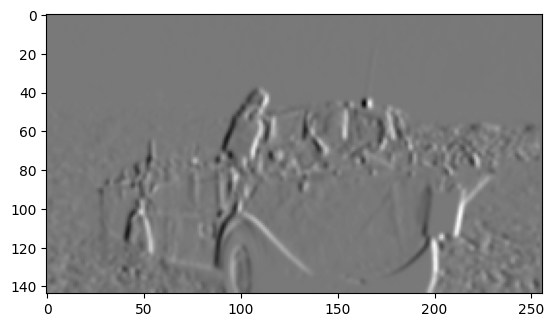

In [27]:
plt.imshow(sobelx, cmap="gray")

In [25]:
SI_mean

917.5630716404781

### Neuron performance vs. neuron position

In [26]:
def split_images(image_ids, responses):
    per_image_repeats = []
    for image_id in np.unique(image_ids):
        responses_across_repeats = responses[image_ids == image_id]
        per_image_repeats.append(responses_across_repeats)

    return per_image_repeats

In [27]:
cell_motor_coord = {}
for dataset in datasets[:5]:
    data_key = dataset.split("_")[1]
    cell_motor_coord[data_key] = np.load(f"./dataset/{dataset}/meta/neurons/cell_motor_coordinates.npy")

In [28]:
for k, v in cell_motor_coord.items():
    print(k, v.shape)

21067-10-18 (8372, 3)
23343-5-17 (7334, 3)
22846-10-16 (7344, 3)
23656-14-22 (8107, 3)
23964-4-22 (8098, 3)


In [29]:
# check the neuron predictivity with neuron position
neuron_pos_corr = pd.DataFrame()
for data_key in data_keys[:5]:
    cur_pos = pd.DataFrame(cell_motor_coord[data_key])
    cur_pos.columns = ["X", "Y", "Z"]
    cur_pos["corr"] = corr(np.vstack(avg_preds_gt[data_key].prediction),
                           np.vstack(avg_preds_gt[data_key].responses), 
                           axis=0)
    cur_pos["data_key"] = data_key
    neuron_pos_corr = pd.concat([neuron_pos_corr, cur_pos], ignore_index=True)

In [30]:
neuron_pos_corr.to_csv("neuron_pos_corr.csv", index=False)

In [31]:
# organize a df for cluster neurons, use image prediction and response as features
neuron_features = pd.DataFrame()
for data_key in data_keys[:5]:
    cur_pos = pd.DataFrame(cell_motor_coord[data_key])
    cur_pos.columns = ["X", "Y", "Z"]
    
    for idx, row in avg_preds_gt[data_key].iterrows():
        image_id = row["image_ids"]
        prediction = np.array(row["prediction"])
        response = np.array(row["responses"])
        
        col_pred = f"{image_id}_preds"
        col_response = f"{image_id}_response"
        cur_pos[col_pred] = prediction
        cur_pos[col_response] = response
        
    cur_pos["data_key"] = data_key
    neuron_features = pd.concat([neuron_features, cur_pos], ignore_index=True)
    
neuron_features.to_csv("neuron_features.csv", index=False)

/tmp/ipykernel_16940/2559991241.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cur_pos[col_response] = response
/tmp/ipykernel_16940/2559991241.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cur_pos[col_pred] = prediction
/tmp/ipykernel_16940/2559991241.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

In [32]:
corr(neuron_features[neuron_features.data_key == "21067-10-18"]["104_preds"].values,
     neuron_features[neuron_features.data_key == "21067-10-18"]["104_response"].values, axis=0)

0.6106725264512787

In [33]:
neuron_pos_feve = pd.DataFrame()
for data_key in data_keys[:5]:
    cur_pos = pd.DataFrame(cell_motor_coord[data_key])
    cur_pos.columns = ["X", "Y", "Z"]
    
    image_ids = preds_gt[data_key].image_ids.values
    the_preds = np.array([ast.literal_eval(x) for x in preds_gt[data_key].prediction.values])
    the_response = np.array([ast.literal_eval(x) for x in preds_gt[data_key].responses.values])
    fev_val, feve_val = fev(
        split_images(image_ids, the_response),
        split_images(image_ids, the_preds),
        return_exp_var=True,
    )
    
    print(feve_val[fev_val >= 0.15].mean())
    cur_pos["feve_all"] = feve_val
    
    feve_val[fev_val < 0.15] = np.nan
    print(np.nanmean(feve_val))
    cur_pos["feve_filter"] = feve_val
    
    cur_pos["data_key"] = data_key
    neuron_pos_feve = pd.concat([neuron_pos_feve, cur_pos], ignore_index=True)

0.5553582971195753
0.5553582971195753
0.6129887011757551
0.6129887011757551
0.6168245466466741
0.6168245466466741
0.552030298143127
0.552030298143127
0.597026008199721
0.597026008199721


In [34]:
neuron_pos_feve.to_csv("neuron_pos_feve.csv", index=False)

In [35]:
image_ids = preds_gt["21067-10-18"].image_ids.values
the_preds = np.array([ast.literal_eval(x) for x in preds_gt["21067-10-18"].prediction.values])
the_response = np.array([ast.literal_eval(x) for x in preds_gt["21067-10-18"].responses.values])

In [36]:
fev_val, feve_val = fev(
    split_images(image_ids, the_response),
    split_images(image_ids, the_preds),
    return_exp_var=True,
)

In [37]:
feve_val[fev_val < 0.15] = np.nan

In [38]:
feve_val[fev_val >= 0.15].max()

1.2255291864926254

### Neuron cluster

In [1]:
import sklearn
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from gap_statistic import OptimalK
from joblib import Parallel, delayed
import umap

/home/dengkw/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calc_wcss_score(X, k, random_state=0):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=random_state)
    kmeans.fit(X)
    wcss = kmeans.inertia_
    return wcss

In [4]:
def calc_silhouette_score(X, k, random_state=0):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, 
                    random_state=random_state)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

In [5]:
# use the predictions
neuron_features = pd.read_csv("./neuron_features.csv")
col_pos = ["X", "Y", "Z"]
col_preds = [col for col in neuron_features.columns if "preds" in col]
col_response = [col for col in neuron_features.columns if "response" in col]

In [6]:
X = neuron_features[col_pos + col_preds]

In [7]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

In [8]:
X[col_preds]

,104_preds,128_preds,183_preds,355_preds,479_preds,483_preds,656_preds,803_preds,830_preds,936_preds,...,6790_preds,6831_preds,6886_preds,7017_preds,7028_preds,7107_preds,7119_preds,7120_preds,7154_preds,7495_preds
0,0.028906,0.387340,0.224511,0.100479,0.293977,0.164184,0.110453,0.616342,0.082232,0.041182,...,0.067892,0.085383,0.046464,0.537416,0.049704,0.808411,0.130916,0.068885,0.216276,0.089953
1,0.094706,0.103867,0.103289,0.146384,0.281236,0.269135,0.058888,0.137319,0.165573,0.255978,...,0.269818,0.170916,0.104432,0.188938,0.075122,0.085263,0.229130,0.102334,0.655441,0.155919
2,0.045486,0.097278,0.027247,0.123161,0.154562,0.429554,0.163180,0.064204,0.168869,0.029786,...,0.089665,0.498429,0.182944,1.084949,0.110800,0.048948,0.277486,0.240416,0.130861,0.033459
3,0.104374,0.209262,0.185753,0.319931,0.299147,1.104742,0.241665,0.399350,0.140664,0.154316,...,0.054919,0.105753,0.145098,0.380851,0.101734,0.202993,0.184044,0.087604,0.266619,0.117186
4,0.013575,0.084431,0.091617,0.110779,0.084724,0.053691,0.144350,1.575783,0.040240,0.034474,...,0.062114,0.264893,0.014182,0.816599,0.034183,0.159670,0.024911,0.081849,0.502117,0.086783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39250,0.089493,0.233628,1.393323,0.054785,0.212539,0.190001,0.324824,1.114342,0.231656,0.066130,...,0.274078,0.160046,0.206088,0.469779,0.338429,0.869388,0.066944,0.233076,0.119336,0.145115
39251,0.145929,0.215154,0.256323,0.061018,0.029958,0.072079,0.083065,0.026976,0.180717,0.175352,...,0.961956,0.161383,0.344859,0.942440,0.086533,0.175361,0.128272,0.467711,0.238345,0.055647
39252,0.058070,0.029194,0.105715,0.152525,0.154456,0.079662,0.275562,1.571104,0.456793,1.057977,...,0.265813,0.125803,0.162589,0.114793,0.079226,0.141836,0.056283,0.078822,0.053015,0.129366
39253,0.090115,0.158319,0.134362,0.305222,0.150687,0.425619,0.068858,0.076678,0.302013,0.097452,...,1.271498,1.688058,0.235610,0.085219,0.172428,0.116421,0.183521,0.183585,0.164638,0.646891


In [11]:
umap_embedding = umap.UMAP(n_neighbors=25).fit_transform(X[col_preds])

In [12]:
umap_embedding2 = umap.UMAP(n_neighbors=25).fit_transform(X[col_pos+col_preds])

In [16]:
umap_embedding3 = umap.UMAP(n_neighbors=25).fit_transform(X[col_pos])

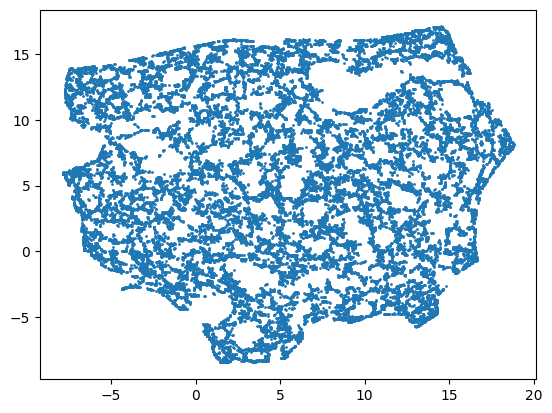

In [14]:
plt.scatter(*umap_embedding2.T, s=1)

In [38]:
kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

Text(0.5, 1.0, '3D t-SNE')

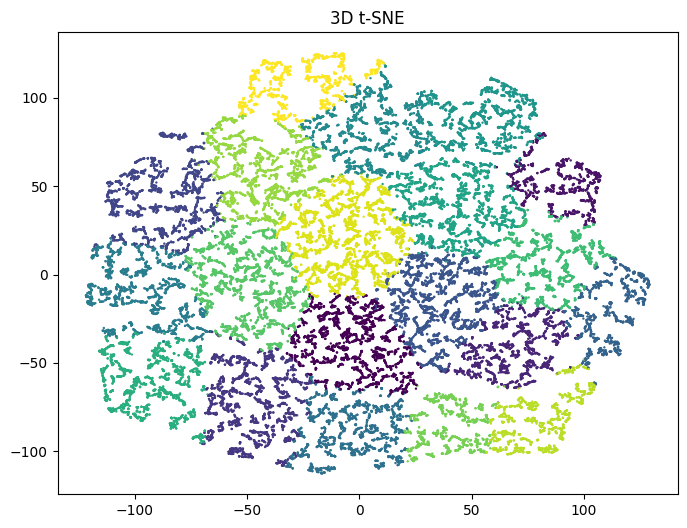

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], s=0.5, c=pred_y)
ax.set_title('3D t-SNE')

In [29]:
wcss_score = Parallel(n_jobs=-1)(delayed(calc_wcss_score)(X, k) for k in range(2, 101))

In [35]:
optimalK = OptimalK(n_jobs=-1, parallel_backend='joblib')
n_clusters = optimalK(X, cluster_array=np.arange(2, 101), n_refs=20)

In [37]:
optimalK.gap_df.head()

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,2.0,0.426349,3.985340e+08,0.082796,1.683480e+09,1.772732e+09,0.014941,1.710919e+09
1,3.0,0.426624,4.630469e+07,0.015217,1.069566e+09,1.097006e+09,0.221879,1.079994e+09
2,4.0,0.217133,2.458917e+07,0.012387,3.901312e+08,4.005588e+08,0.024569,3.994635e+08
3,5.0,0.210793,3.017339e+07,0.018230,3.187788e+08,3.281111e+08,-0.060249,3.293743e+08
4,6.0,0.294927,3.339091e+07,0.023884,3.659776e+08,3.765730e+08,0.078054,3.776826e+08


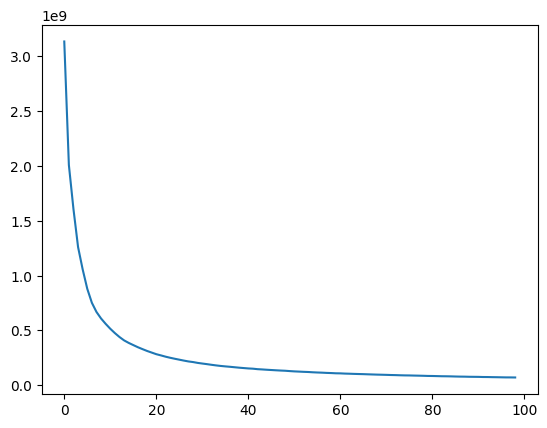

In [32]:
plt.plot(wcss_score)